In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df=pd.read_csv("naya_df.csv")

In [3]:
df.head()

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities,Class
0,0,1.741693e+09,0.1051,1.043395e+09,6.982980e+08,301963000.0,658601000.0,3.969700e+07,65412000.0,-1.549900e+07,...,0,0,0,0,0,0,0,0,0,0
1,1,2.274038e+09,0.3056,1.447354e+09,8.266840e+08,341064000.0,709930000.0,1.167540e+08,62022000.0,6.789600e+07,...,0,0,0,0,0,0,0,0,0,0
2,2,1.640300e+10,0.1061,1.198000e+10,4.423000e+09,477000000.0,733000000.0,3.690000e+09,801000000.0,2.704000e+09,...,0,0,0,0,0,0,0,0,0,0
3,3,1.862800e+10,0.1356,1.344500e+10,5.183000e+09,443000000.0,429000000.0,4.754000e+09,945000000.0,3.593000e+09,...,0,0,0,0,0,0,0,0,0,1
4,4,1.620812e+10,-0.0141,1.418222e+10,2.025907e+09,596761000.0,596761000.0,1.429146e+09,169244000.0,1.194514e+09,...,0,0,0,0,0,0,0,0,0,1


In [4]:
df.drop(['Unnamed: 0', 'Country'], axis=1, inplace=True)

In [5]:

# split into train and test
df_train, df_test = train_test_split(df, train_size=0.7, test_size = 0.3, random_state=747)

In [6]:
# scaling the features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
var = list(df_train.columns)
df_train[var] = scaler.fit_transform(df_train[var])

df_test[var] = scaler.transform(df_test[var])

In [7]:
#pop will remove the column and return it to y_train
y_train = df_train.pop("Class")
X_train = df_train

y_test = df_test.pop("Class")
X_test = df_test

In [24]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 70)
rfe = rfe.fit(X_train, y_train)

In [25]:
lasso = Lasso()

# list of alphas

# params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
#                     9.0, 10.0, 20, 50, 100, 500, 1000 ]}


params ={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]} 
#Commented the first params because it gives same optimum alpha of 0.0001 but this range gives better resulting graph



# cross validation

folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    1.6s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                   0.001, 0.002, 0.003, 0.004, 0.005, 0.01]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [26]:
# display the mean scores

lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
0,0.0001,-0.446192,-0.461907,1
1,0.0002,-0.451373,-0.463354,2
2,0.0003,-0.455063,-0.464404,3
3,0.0004,-0.457801,-0.465397,4
4,0.0005,-0.460036,-0.466517,5
5,0.001,-0.466430,-0.470929,6
6,0.002,-0.474584,-0.477380,7
7,0.003,-0.478258,-0.479998,8
8,0.004,-0.480028,-0.481682,9
9,0.005,-0.481492,-0.482980,10


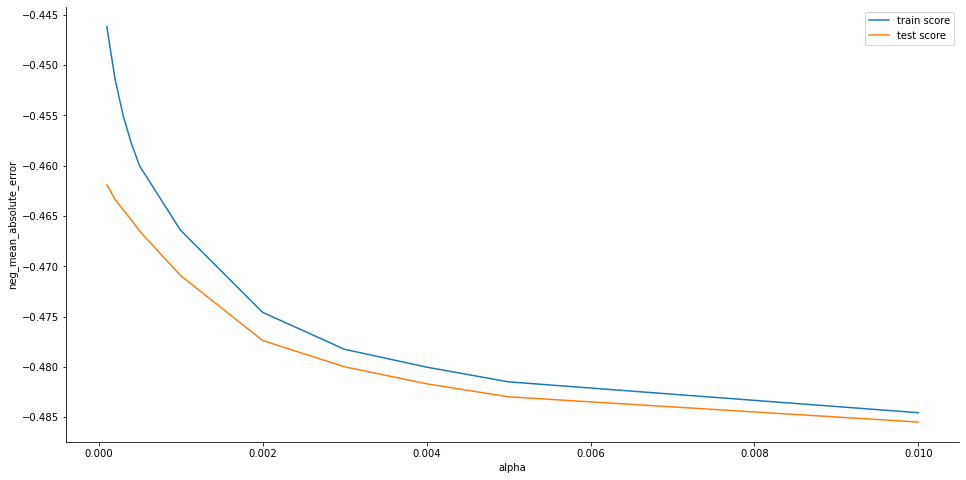

In [27]:
# plotting mean test and train scoes with alpha 

lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float64')

# plotting
plt.figure(figsize=(16,8))
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('neg_mean_absolute_error')

sns.despine()
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [28]:

# get the best estimator for lambda

lasso_model_cv.best_estimator_

Lasso(alpha=0.0001)

In [29]:
# check the coefficient values with lambda = 0.0001

alpha = 0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 
lasso.coef_

array([ 0.        ,  0.        ,  0.        ,  0.19402828,  0.04354451,
        0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.08023825,  0.18513808,  0.        ,
        0.03376768,  0.23213787,  0.19206865,  0.        ,  0.        ,
        0.47105734,  0.19297599, -0.        , -0.        , -1.06846378,
        0.        ,  0.        , -0.06222897, -0.        ,  0.        ,
       -1.00264825, -0.        , -0.        , -0.10776958, -0.22093227,
       -0.        , -0.        ,  0.22510883, -0.        , -0.00207002,
       -0.        ,  0.0845368 , -0.01829265,  0.09134625,  0.22556351,
       -0.        ,  0.56290042, -0.        ,  0.0251535 ,  0.20827405,
        0.        , -0.07594118,  0.        ,  0.28252286, -0.        ,
       -0.        , -0.26078311, -0.29933843,  0.        , -1.14030237,
        0.        ,  0.        ,  0.37018124,  0.        ,  0.10951735,
       -0.1387383 ,  0.30474338,  0.        ,  0.02621171,  0.24

In [30]:
# Check the mean squared error

mean_squared_error(y_test, lasso.predict(X_test))


0.23815556258114298

In [31]:

# Put the shortlisted Features and coefficienst in a dataframe

lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(2)})

print("Shape before zero coefficients are removed: ",lasso_df.shape)

lasso_df = lasso_df[lasso_df['Coefficient'] != 0.00]

print("Shape after zero coefficients are removed:  ",lasso_df.shape)

lasso_df.reset_index(drop=True, inplace=True)
lasso_df

Shape before zero coefficients are removed:  (170, 2)
Shape after zero coefficients are removed:   (84, 2)


,Features,Coefficient
0,Gross Profit,0.19
1,SG&A Expense,0.04
2,EPS,0.08
3,EPS Diluted,0.19
4,Weighted Average Shs Out (Dil),0.03
...,...,...
79,Book Value per Share Growth,-0.18
80,SG&A Expenses Growth,-0.24
81,Healthcare,0.04
82,Industrials,0.05


In [32]:
# Put the Features and Coefficients in dictionary

lasso_coeff_dict = dict(pd.Series(lasso.coef_, index = X_train.columns))
lasso_coeff_dict

{'Revenue': 0.0,
 'Revenue Growth': 0.0,
 'Cost of Revenue': 0.0,
 'Gross Profit': 0.1940282809011898,
 'SG&A Expense': 0.04354451445927603,
 'Operating Expenses': 0.0,
 'Operating Income': 0.0,
 'Interest Expense': 0.0,
 'Earnings before Tax': -0.0,
 'Income Tax Expense': -0.0,
 'Net Income': -0.0,
 'Net Income Com': -0.0,
 'EPS': 0.0802382541601469,
 'EPS Diluted': 0.18513808488805633,
 'Weighted Average Shs Out': 0.0,
 'Weighted Average Shs Out (Dil)': 0.03376768370909271,
 'Dividend per Share': 0.232137867340999,
 'Gross Margin': 0.1920686473688569,
 'EBITDA Margin': 0.0,
 'EBIT Margin': 0.0,
 'Profit Margin': 0.47105733759040247,
 'Free Cash Flow margin': 0.19297599297768278,
 'EBITDA': -0.0,
 'EBIT': -0.0,
 'Consolidated Income': -1.0684637848753704,
 'Earnings Before Tax Margin': 0.0,
 'Net Profit Margin': 0.0,
 'Cash and cash equivalents': -0.062228969253264106,
 'Cash and short-term investments': -0.0,
 'Receivables': 0.0,
 'Inventories': -1.0026482548476918,
 'Total current a

In [33]:
# Method to get the coefficient values

def find(x):
    return lasso_coeff_dict[x]


X_train_lasso = X_train[lasso_df.Features]



In [34]:

lasso_temp_df = pd.DataFrame(list(zip( X_train_lasso.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
lasso_temp_df = lasso_temp_df.loc[lasso_temp_df['rfe_support'] == True]
lasso_temp_df.reset_index(drop=True, inplace=True)

lasso_temp_df['Coefficient'] = lasso_temp_df['Features'].apply(find)
lasso_temp_df = lasso_temp_df.sort_values(by=['Coefficient'], ascending=False)
lasso_temp_df

,Features,rfe_support,rfe_ranking,Coefficient
35,Average Inventory,True,1,1.042989
33,Earnings Yield,True,1,0.568211
14,Investments,True,1,0.562900
4,Profit Margin,True,1,0.471057
22,priceToOperatingCashFlowsRatio,True,1,0.304743
17,Investment purchases and sales,True,1,0.282523
41,3Y Shareholders Equity Growth (per Share),True,1,0.275102
38,Operating Cash Flow growth,True,1,0.263510
11,Short-term debt,True,1,0.225109
15,Stock-based compensation,True,1,0.208274


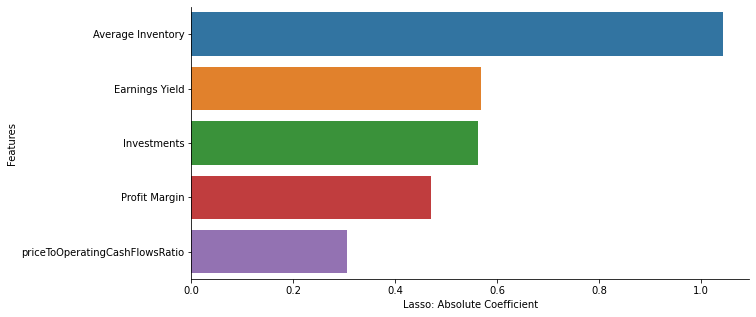

In [56]:
# bar plot to determine the variables that would affect pricing most using ridge regression

plt.figure(figsize=(10,5))
lasso_temp_df_pos = lasso_temp_df.copy()
lasso_temp_df_pos['Coefficient'] = abs(lasso_temp_df_pos['Coefficient'] )

sns.barplot(y = 'Features', x='Coefficient',  data = lasso_temp_df_pos.head(5)).set(xlabel='Lasso: Absolute Coefficient')
sns.despine()

plt.show()

# Ridge

In [38]:
# list of alphas

params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation

folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  #r2 can also be used (both give similar lambda in our case)
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    1.5s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
                                   1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [39]:
# display the mean scores

ridge_cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
ridge_cv_results = ridge_cv_results[ridge_cv_results['param_alpha']<=1000]
ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
3,0.1,-0.440610,-0.461266,1
4,0.2,-0.442093,-0.461351,2
5,0.3,-0.443108,-0.461501,3
6,0.4,-0.443932,-0.461701,4
7,0.5,-0.444644,-0.461890,5
8,0.6,-0.445272,-0.462065,6
9,0.7,-0.445828,-0.462218,7
10,0.8,-0.446336,-0.462357,8
11,0.9,-0.446803,-0.462506,9
12,1,-0.447242,-0.462659,10


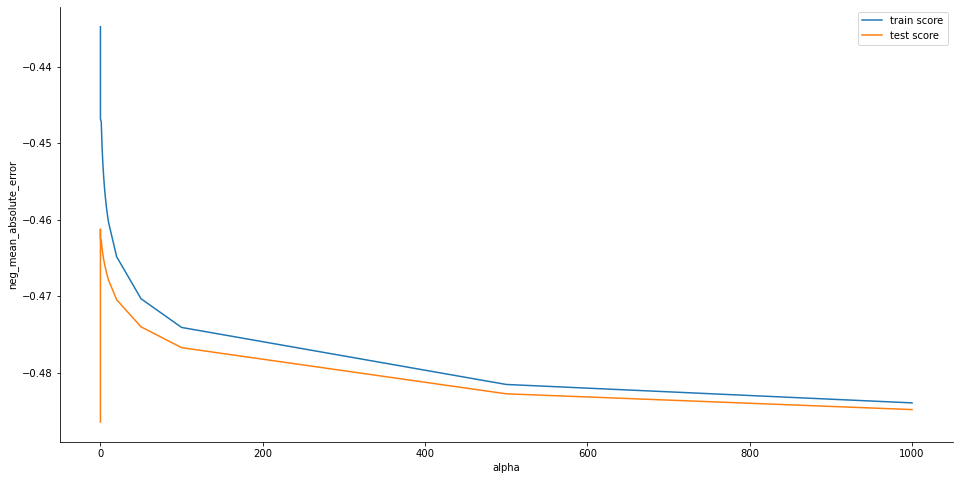

In [40]:
# plotting mean test and train scoes with alpha 

ridge_cv_results['param_alpha'] = ridge_cv_results['param_alpha'].astype('int32')

# plotting
plt.figure(figsize=(16,8))
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_train_score'])
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('neg_mean_absolute_error')

sns.despine()
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [41]:
# get the best estimator for lambda

ridge_model_cv.best_params_

{'alpha': 0.1}

In [42]:
# check the coefficient values with lambda = 1

ridge = Ridge(alpha=0.1)

ridge.fit(X_train, y_train)
ridge.coef_

array([ 1.61253397e-01,  3.24822451e-01, -8.72302929e-03,  3.77355586e-01,
        2.89663735e-02, -1.51243095e-01,  1.24906958e-01,  2.89739054e-01,
       -2.50033452e-01,  1.00802950e-01, -1.62241425e-01,  1.22326519e-01,
        5.03648658e-01,  5.05295634e-01, -2.15946501e-01,  3.10671906e-01,
        2.34432800e-01, -6.77876962e-02,  2.46925752e-01,  6.44954748e-02,
        3.28747944e-01,  1.96101178e-01, -3.38118884e-01, -1.88352663e-01,
       -8.53390982e-01,  1.51021183e-01,  5.46853792e-01, -9.13153980e-03,
        1.33535369e-02, -9.21856414e-02, -1.98386424e+00, -5.91693480e-01,
       -2.56834015e-01, -4.11905242e-01, -2.37434324e-01,  2.41504233e-01,
       -7.11390307e-01,  1.42684161e-01,  3.97030783e-01, -5.96888647e-01,
        3.96027051e-01,  1.83552745e-01, -3.47033747e-01,  1.12995836e-01,
        4.40387599e-01,  5.58721631e-02,  8.25024504e-01,  5.83396035e-01,
        1.46521521e-01,  2.32625015e-01, -7.65446101e-03, -1.28860609e-01,
        2.02549675e-01,  

In [43]:

# Check the mean squared error

mean_squared_error(y_test, ridge.predict(X_test))

0.26126804512432916

In [44]:
# Put the Features and coefficienst in a dataframe

ridge_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4)})
ridge_df.reset_index(drop=True, inplace=True)
print("Ridge DataFrame Shape:", ridge_df.shape)
ridge_df.head(10)


Ridge DataFrame Shape: (170, 2)


,Features,Coefficient
0,Revenue,0.1613
1,Revenue Growth,0.3248
2,Cost of Revenue,-0.0087
3,Gross Profit,0.3774
4,SG&A Expense,0.0290
5,Operating Expenses,-0.1512
6,Operating Income,0.1249
7,Interest Expense,0.2897
8,Earnings before Tax,-0.2500
9,Income Tax Expense,0.1008


In [46]:
 #Assign the Features and their coefficient values to a dictionary which would be used while plotting the bar plot

ridge_coeff_dict = dict(pd.Series(ridge.coef_.round(4), index = X_train.columns))
ridge_coeff_dict

{'Revenue': 0.1613,
 'Revenue Growth': 0.3248,
 'Cost of Revenue': -0.0087,
 'Gross Profit': 0.3774,
 'SG&A Expense': 0.029,
 'Operating Expenses': -0.1512,
 'Operating Income': 0.1249,
 'Interest Expense': 0.2897,
 'Earnings before Tax': -0.25,
 'Income Tax Expense': 0.1008,
 'Net Income': -0.1622,
 'Net Income Com': 0.1223,
 'EPS': 0.5036,
 'EPS Diluted': 0.5053,
 'Weighted Average Shs Out': -0.2159,
 'Weighted Average Shs Out (Dil)': 0.3107,
 'Dividend per Share': 0.2344,
 'Gross Margin': -0.0678,
 'EBITDA Margin': 0.2469,
 'EBIT Margin': 0.0645,
 'Profit Margin': 0.3287,
 'Free Cash Flow margin': 0.1961,
 'EBITDA': -0.3381,
 'EBIT': -0.1884,
 'Consolidated Income': -0.8534,
 'Earnings Before Tax Margin': 0.151,
 'Net Profit Margin': 0.5469,
 'Cash and cash equivalents': -0.0091,
 'Cash and short-term investments': 0.0134,
 'Receivables': -0.0922,
 'Inventories': -1.9839,
 'Total current assets': -0.5917,
 'Property, Plant & Equipment Net': -0.2568,
 'Goodwill and Intangible Assets'

In [47]:
X_train_ridge = X_train[ridge_df.Features]


In [48]:
# Method to get the coefficient values

def find(x):
    return ridge_coeff_dict[x]

# Assign top features to a temp dataframe for further display in the bar plot

ridge_temp_df = pd.DataFrame(list(zip( X_train.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
ridge_temp_df = ridge_temp_df.loc[ridge_temp_df['rfe_support'] == True]
ridge_temp_df.reset_index(drop=True, inplace=True)

ridge_temp_df['Coefficient'] = ridge_temp_df['Features'].apply(find)
ridge_temp_df = ridge_temp_df.sort_values(by=['Coefficient'], ascending=False)
ridge_temp_df

,Features,rfe_support,rfe_ranking,Coefficient
63,Average Inventory,True,1,2.0988
54,Earnings Yield,True,1,1.2605
58,Stock-based compensation to Revenue,True,1,0.9405
36,priceSalesRatio,True,1,0.8173
33,Investment purchases and sales,True,1,0.7835
...,...,...,...,...
18,Consolidated Income,True,1,-0.8534
56,Capex to Operating Cash Flow,True,1,-0.8748
39,pretaxProfitMargin,True,1,-0.9496
34,Effect of forex changes on cash,True,1,-1.1508


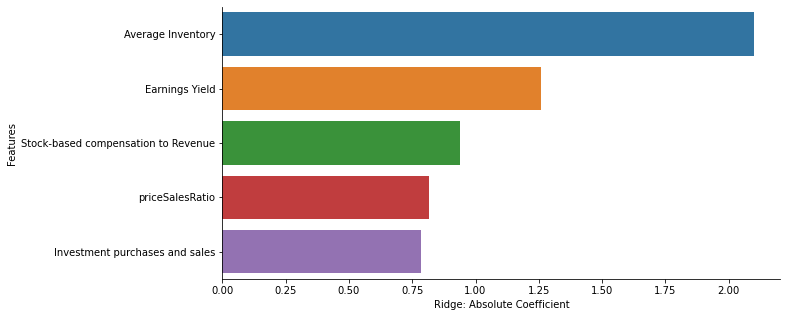

In [55]:
# bar plot to determine the variables that would affect pricing most using ridge regression

ridge_temp_df_pos = ridge_temp_df.copy()
ridge_temp_df_pos['Coefficient'] = abs(ridge_temp_df_pos['Coefficient'] )

plt.figure(figsize=(10,5))
sns.barplot(y = 'Features', x='Coefficient', data = ridge_temp_df_pos.head(5)).set(xlabel='Ridge: Absolute Coefficient')
sns.despine()
plt.show()